<a href="https://colab.research.google.com/github/bartala/Bankruptcy/blob/main/R_PY_before_covid_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.0.0

In [ ]:
%load_ext rpy2.ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%R
lib_loc <- "/content/drive/MyDrive/Colab Notebooks/r-lib"

In [ ]:
%%R
install.packages("data.table", lib =lib_loc)
install.packages("ggpubr",lib =lib_loc)
install.packages("DescTools", lib =lib_loc)
install.packages("NbClust", lib =lib_loc)
install.packages("factoextra", lib =lib_loc)
install.packages("gsubfn", lib =lib_loc)
install.packages("proto", lib =lib_loc)
install.packages("ggplot2", lib =lib_loc)
install.packages("RSQLite", lib =lib_loc)
install.packages("sqldf", lib=lib_loc)
install.packages("chron",lib= lib_loc)
install.packages("minpack.lm",repos = "http://cran.us.r-project.org",lib=lib_loc)
install.packages("AICcmodavg",repos = "http://cran.us.r-project.org", lib=lib_loc)
install.packages("gridExtra",repos = "http://cran.us.r-project.org", lib=lib_loc)+
install.packages("rsq",repos = "http://cran.us.r-project.org", lib=lib_loc)


In [ ]:
%%R
library(RSQLite, lib.loc = lib_loc)
library(proto, lib.loc = lib_loc) 
library(gsubfn, lib.loc = lib_loc) 
library(readr, lib.loc = lib_loc)
library(ggplot2, lib.loc = lib_loc)
library(ggpubr, lib.loc = lib_loc)
library(pROC, lib.loc = lib_loc)
library(DescTools, lib.loc = lib_loc)
library(NbClust, lib.loc = lib_loc)
library(factoextra, lib.loc = lib_loc)
library(sqldf, lib.loc = lib_loc)
library(cowplot,lib.loc = lib_loc)
library(AICcmodavg,lib.loc = lib_loc)
library(minpack.lm,lib.loc = lib_loc)
library(gridExtra,lib.loc = lib_loc)
library(rsq,lib.loc = lib_loc)
library(broom)

In [ ]:
%%R

# before covid data
PTH1 = "/content/drive/MyDrive/Colab Notebooks/BIU_HEB/data/before_covid_data"

### Load datasets of tweets posted before and after the announcment

In [ ]:
%%R

after <- read_csv(paste0(PTH1,"/after.csv"),col_types = cols(...1 = col_skip(), id = col_character(),
                                                                     conversation_id = col_character(),
                                                                     author_id = col_character(), 
                                                                     in_reply_to_user_id = col_character()))

before <- read_csv(paste0(PTH1,"/before.csv"),col_types = cols(...1 = col_skip(), id = col_character(),
                                                                       in_reply_to_user_id = col_character(),
                                                                       author_id = col_character(), 
                                                                       conversation_id = col_character()))

• `` -> `...1`

• `` -> `...1`



### Descriptive statistics and data cleaning

In [ ]:
%%R

# nuber of unique users in the posts
print(paste0("unique users: ",
              length(
                        union(after$author_id,before$author_id)
                        )
            )
    )


# total number of tweets
print(
    paste0("total number of tweets (before and after the announcement): ",
           nrow(before) + nrow(after)
          )
      )

# number of tweets per company
table(after$company)

[1] "unique users: 26915"
[1] "total number of tweets (before and after the announcement): 40125"

   beautybrands  CharlotteRusse CharmingCharlie         claires          DIESEL 
             66             326              15            4479             733 
      Forever21      ftdflowers         hhgregg   KikoMilanoUSA    MattressFirm 
           4665              98             491              69            1192 
       NineWest      Perfumania        Rockport           rue21           Sears 
            345             398             131            1425            7034 
      sugarfina    TrueReligion 
            125            1134 


In [ ]:
%%R

companies = data.frame(
    user_id = c(  '568555816',
                  '28384755',
                  '44379956',
                  '204812327',
                  '205671915',
                  '9635662',
                  '137761841',
                  '19464428',
                  '18455097',
                  '69634216',
                  '115748758',
                  '22148825',
                  '94142495',
                  '23860949',
                  '17972364',
                  '23480462'
                        ),
   user_name = c( 'sugarfina',
                  'Forever21',
                  'CharmingCharlie',
                  'ftdflowers',
                  'DIESEL',
                  'CharlotteRusse',
                  'beautybrands',
                  'Sears',
                  'MattressFirm',
                  'Rockport',
                  'NineWest',
                  'claires',
                  'Perfumania',
                  'TrueReligion',
                  'rue21',
                  'hhgregg'
      )
 )



x_after <- nrow(after)
x_before <- nrow(before)

# delete messages originated by the companies
after <- after[!after$author_id %in% companies$user_id,]
before <- before[!before$author_id %in% companies$user_id,]

print( paste0("deleted tweets by companies after: ", x_after - nrow(after) ) )
print( paste0("deleted tweets by companies before: ", x_before - nrow(before) ) )

[1] "deleted tweets by companies after: 52"
[1] "deleted tweets by companies before: 23"


### Temporal analysis: number of mentions per day and company

In [ ]:
%%R

before$created_at<-as.character(before$created_at)
after$created_at<-as.character(after$created_at)

# keep only day date (no time)
before$date <- substr(before$created_at,0,10)
after$date <- substr(after$created_at,0,10)

temp_before <- sqldf("select company, date, count(1) as freq from before group by company, date")

temp_before$when<-'before'

temp_after <- sqldf("select company, date, count(1) as freq 
                      from after group by company, date")

temp_after$when<-'after'

tmp <- rbind(temp_before, temp_after)

# save temporary file for future analyses
write.csv(tmp,file='data0.csv')

In [ ]:
import pandas as pd

SHEET_ID = '1XSarc8ncWfJzZ2MmQI6ysPNeEPmXk9C3I7leca-k3q0'
SHEET_NAME = 'Sheet1'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df = pd.read_csv(url)
df['Date_of_Bankruptcy'] = pd.to_datetime(df["Date of Bankruptcy"]).dt.strftime('%Y-%m-%d')
df = df[['Twitter Username', 'Date_of_Bankruptcy']]

In [ ]:
# move df into R
%R -i df

In [ ]:
%%R 
tmp <- merge(tmp,df, by.x='company', by.y='Twitter.Username')

tmp$number <- as.Date(tmp$date) - as.Date(tmp$Date_of_Bankruptcy) # day diff from bankruptcy

tmp <- tmp[!tmp$company %in% c('KikoMilanoUSA','CharmingCharlie'),]

In [ ]:
'''
%%R
# do manual processing on data0.csv to calc days since bankrupt announcment
# and then, read the file

tmp <- read_csv("/content/drive/MyDrive/Colab Notebooks/BIU_HEB/data/data_rebuttle.csv")

tmp <- tmp[tmp$company != 'KikoMilanoUSA',]

head(tmp)

#write.csv(tmp,file='data.csv')
'''

In [ ]:
# calc avg. mention time before and after the bankruptcy announcment

%%R

df1 <- sqldf("select company, avg(freq) as avg_freq from tmp where `when`='after' group by company")
df1$When = "After"

df2 <- sqldf("select company, avg(freq) as avg_freq from tmp where `when`='before' group by company")
df2$When = "Before"

df_1 <- rbind(df1,df2)

df_1

          company   avg_freq   When
1  CharlotteRusse  11.642857  After
2          DIESEL  23.645161  After
3       Forever21 155.500000  After
4    MattressFirm  38.000000  After
5        NineWest  11.896552  After
6      Perfumania  15.920000  After
7        Rockport   4.481481  After
8           Sears 226.483871  After
9    TrueReligion  36.548387  After
10   beautybrands   4.400000  After
11        claires 144.161290  After
12     ftdflowers   3.769231  After
13        hhgregg  15.838710  After
14          rue21  45.870968  After
15      sugarfina   4.592593  After
16 CharlotteRusse   7.633333 Before
17         DIESEL  23.888889 Before
18      Forever21 172.766667 Before
19   MattressFirm  18.344828 Before
20       NineWest   6.633333 Before
21     Perfumania  16.782609 Before
22       Rockport   4.913043 Before
23          Sears 130.689655 Before
24   TrueReligion   9.827586 Before
25   beautybrands   1.954545 Before
26        claires  71.740741 Before
27     ftdflowers  19.857143

#### Companies with more tweets after the announcement (on average) than before the announcment 

(i.e., they were not forgotten by the public)


In [ ]:
%%R 
df_2 <- data.frame(
              Company = df1$company, 
              After = df1$avg_freq, 
              Before = df2$avg_freq
              )

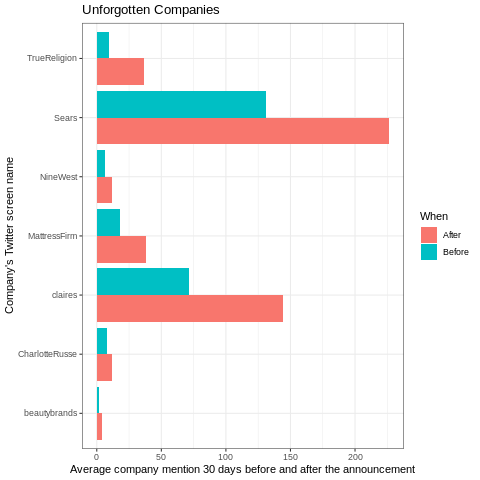

In [ ]:
# unforgotten companies
%%R
ggplot(df_1[df_1$company %in% (df_2[df_2$After >= df_2$Before,'Company']),], aes(company, avg_freq, fill=When)) +
  geom_bar(stat = "identity", position = 'dodge') +
  theme_bw() +
  ggtitle("Unforgotten Companies") +
  ylab("Average company mention 30 days before and after the announcement") + xlab("Company's Twitter screen name")+
  coord_flip()

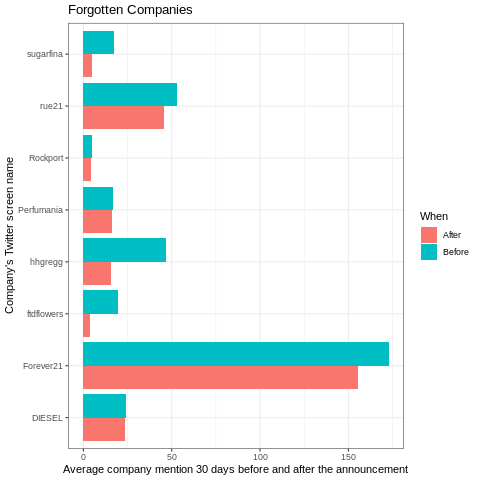

In [ ]:
# forgotten companies
%%R
ggplot(df_1[df_1$company %in% (df_2[df_2$After < df_2$Before,'Company']),], aes(company, avg_freq, fill=When)) +
  geom_bar(stat = "identity", position = 'dodge') +
  theme_bw() +
  ggtitle("Forgotten Companies") +
  ylab("Average company mention 30 days before and after the announcement") + xlab("Company's Twitter screen name")+
  coord_flip()

In [ ]:
%R tmp

,company,date,freq,when,Date_of_Bankruptcy,number
1,beautybrands,2018-12-06,1,before,2019-01-06,-31.0
2,beautybrands,2018-12-24,1,before,2019-01-06,-13.0
3,beautybrands,2018-12-25,1,before,2019-01-06,-12.0
4,beautybrands,2018-12-27,2,before,2019-01-06,-10.0
5,beautybrands,2018-12-28,3,before,2019-01-06,-9.0
...,...,...,...,...,...,...
860,TrueReligion,2017-07-30,15,after,2017-07-05,25.0
861,TrueReligion,2017-07-31,7,after,2017-07-05,26.0
862,TrueReligion,2017-08-01,5,after,2017-07-05,27.0
863,TrueReligion,2017-08-02,13,after,2017-07-05,28.0


### Model comparison: AVG tweets vs. days since bankruptcy

In [ ]:
# Unforgotten companies

%%R

Unforgotten <- tmp[ (tmp$company) %in% (df_2[df_2$After >= df_2$Before,'Company']) & tmp$number >=0, ] # number:= number of days since bankruptcy announcement

Unforgotten <- sqldf("select avg(freq) as avg, number from Unforgotten group by number",method = "name__class")


# number of companies
print( df_2[df_2$After >= df_2$Before,'Company'] )

[1] "CharlotteRusse" "MattressFirm"   "NineWest"       "Sears"         
[5] "TrueReligion"   "beautybrands"   "claires"       


In [263]:
# models
%%R

Unforgotten$x = Unforgotten$number
Unforgotten$y = Unforgotten$avg

# Exponential
expmodel <- lm(y~exp(x), data = Unforgotten)
print(summary(expmodel))

# Log
logmodel <- lm(y~log(x+0.01), data = Unforgotten)
print(summary(logmodel))

# Hyperbolic
hyper_fit <- nlsLM(y ~ a/(1 + b * x), data = Unforgotten, start = list(a = 1, b = 1))
print(summary(hyper_fit))

# Biexponential
biexp_fit <- nlsLM(y ~ a1*exp(-b1*x) + a2*exp(-b2*x), data = Unforgotten, start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))
print(summary(biexp_fit))

# Fit a power law curve using nls
power_fit <- nls(y ~ a * (x+0.0001)^(-b), data = Unforgotten, start = list(a = 1, b = 1))
summary(power_fit)


Call:
lm(formula = y ~ exp(x), data = Unforgotten)

Residuals:
   Min     1Q Median     3Q    Max 
-51.71 -40.25 -30.33   2.28 381.00 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.400e+01  1.713e+01   4.321 0.000166 ***
exp(x)      -6.635e-13  8.297e-12  -0.080 0.936806    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 91.96 on 29 degrees of freedom
Multiple R-squared:  0.0002205,	Adjusted R-squared:  -0.03425 
F-statistic: 0.006396 on 1 and 29 DF,  p-value: 0.9368


Call:
lm(formula = y ~ log(x + 0.01), data = Unforgotten)

Residuals:
    Min      1Q  Median      3Q     Max 
-68.192 -38.921  -6.265  23.877 140.866 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    185.627     16.484   11.26 4.18e-12 ***
log(x + 0.01)  -49.529      6.077   -8.15 5.49e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 50.7 on 29 degr

In [193]:
%%R 

gof <- function(model){
    
    return( 
              glance(model) %>% 
                  dplyr::select(adj.r.squared, sigma, AIC, BIC, p.value)
    )

}



print(paste0("AIC exp: ", gof(expmodel)$AIC))
print(paste0("AIC log: ",gof(logmodel)$AIC))
print(paste0("AIC hypr: ",AIC(hyper_fit)))
print(paste0("AIC biex: ",AIC(biexp_fit)))
print(paste0("AIC power: ",AIC(power_fit)))

[1] "AIC exp: 372.23167611912"
[1] "AIC log: 335.315558286263"
[1] "AIC hypr: 366.882380109537"
[1] "AIC biex: 307.330233703395"
[1] "AIC power: 336.935250756214"


In [290]:
# clac R^2 for non-linear models
%%R
r_sqared <- function(model){
    
                    y <- Unforgotten$y
                    # Calculate R-squared
                    y_hat <- predict(model) # predicted values
                    rss <- sum(resid(model)^2) # residual sum of squares
                    tss <- sum((y - mean(y))^2) # total sum of squares
                    r_squared <- 1 - rss/tss # R-squared
                    return(r_squared)

}

print(paste0("AIC exp: ",   round(r_sqared(expmodel),2)))
print(paste0("AIC log: ",   round(r_sqared(logmodel),2)))
print(paste0("AIC hypr: ",  round(r_sqared(hyper_fit),2)))
print(paste0("AIC biex: ",  round(r_sqared(biexp_fit),2)))
print(paste0("AIC power: ", round(r_sqared(power_fit),2)))

[1] "AIC exp: 0"
[1] "AIC log: 0.7"
[1] "AIC hypr: 0.16"
[1] "AIC biex: 0.89"
[1] "AIC power: 0.68"


In [ ]:
%%R
shift = mean(Unforgotten[Unforgotten$x>6,'y'])
shift

[1] 47.80476


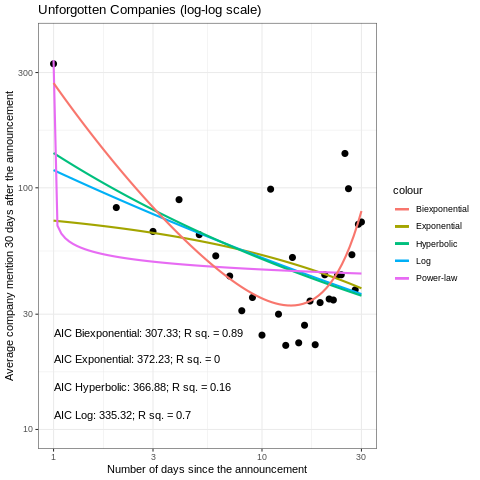

In [302]:
%%R

ggplot(Unforgotten, aes(x=number, y=avg)) + 
  geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
  scale_x_continuous(trans = "log10", limits = c(1, 30)) +
  scale_y_continuous(trans = "log10", limits = c(10, 400)) +
  #coord_cartesian(ylim = c(0,500)) +
  geom_smooth(method="lm", aes(color="Exponential"), formula= (y ~ exp(x)), se=FALSE, linetype = 1) +
  geom_smooth(method = "glm", aes(color="Log"), formula = y~x, se=FALSE, method.args = list(family = gaussian(link = 'log')),linetype = 1) +
  geom_smooth(method = "nls", aes(color = "Hyperbolic"), formula = y ~ a/(1 + b * x), start = list(a = 1, b = 1), se = FALSE, linetype = 1) +
  geom_smooth(method = "nls", aes(color = "Power-law"), formula = y ~ a * (x+0.0000001)^(-b), se = FALSE, method.args = list(start = list(a = 1, b = 1))) +
  geom_smooth(method = "nls", aes(color = "Biexponential"), formula = y ~ a1*exp(-b1*x) + a2*exp(-b2*x), se = FALSE, method.args = list(start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))) +
  #geom_smooth(method = "nls", aes(color = "Shifted power-law"), formula = y ~ a * (x+0.00001)^(-b) + shift, se = FALSE, method.args = list(start = list(a = 1, b = 1))) +
  ggtitle("Unforgotten Companies (log-log scale)") +
    ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
  annotate("text", x=1, y=25,  label= paste0("AIC Biexponential: ",round(AIC(biexp_fit),2),"; R sq. = " ,round(r_sqared(biexp_fit),2)),hjust = 0)+
  annotate("text", x=1, y=19.5, label= paste0("AIC Exponential: ", round(gof(expmodel)$AIC,2), "; R sq. = " ,round(r_sqared(expmodel),2)),hjust = 0) +
  annotate("text", x=1, y=15, label= paste0("AIC Hyperbolic: ",round(AIC(hyper_fit),2), "; R sq. = " ,round(r_sqared(hyper_fit),2)),hjust = 0)+
  annotate("text", x=1, y=11.5, label= paste0("AIC Log: ",round(gof(logmodel)$AIC,2),"; R sq. = " ,round(r_sqared(logmodel),2)),hjust = 0)+
  annotate("text", x=1, y=9, label= paste0("AIC Power-law: ",round(AIC(power_fit),2),"; R sq. = " ,round(r_sqared(power_fit),2)),hjust = 0)+
  theme_bw()

In [216]:
%R round(AIC(biexp_fit),2)

array([307.33])

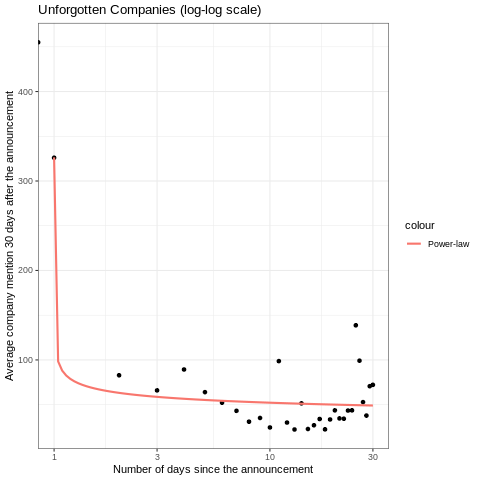

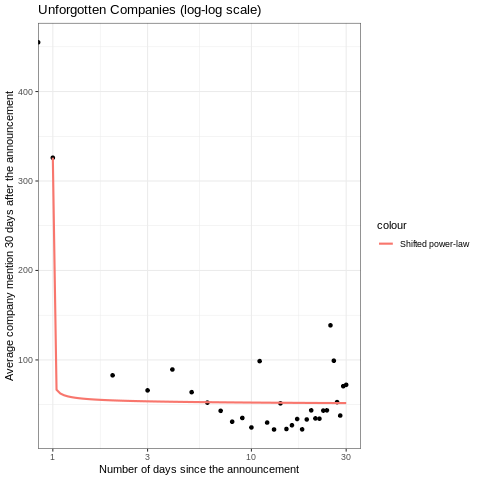

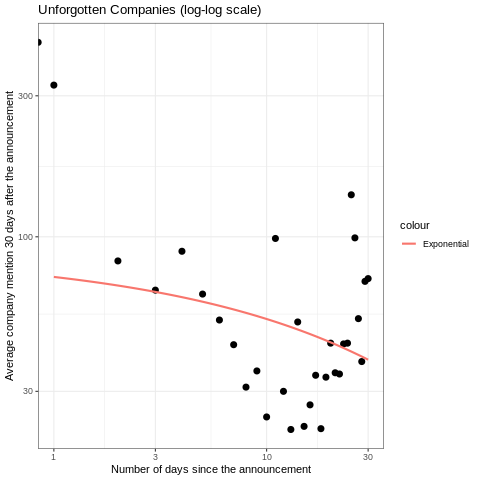

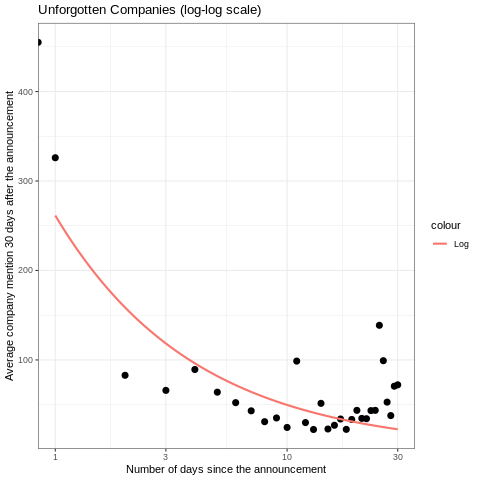

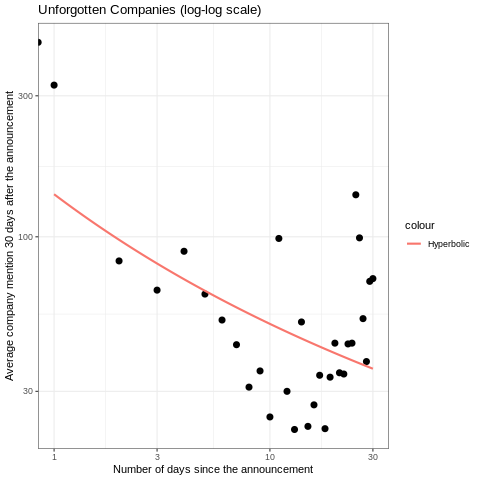

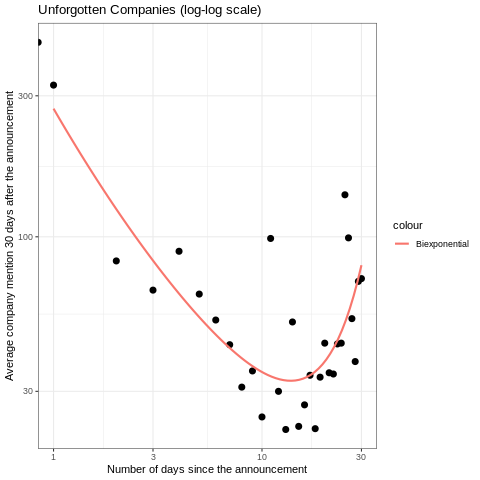

In [152]:
%%R

Power_law <- ggplot(Unforgotten, aes(x=number, y=avg)) + 
                      geom_point() +
                      scale_x_continuous(trans = "log10") +
                      #scale_y_continuous(trans = "log10") +
                      geom_smooth(method = "nls", aes(color = "Power-law"), formula = y ~ a * (x+0.00001)^(-b), se = FALSE, method.args = list(start = list(a = 1, b = 1))) +
                      ggtitle("Unforgotten Companies (log-log scale)") +
                        ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
                      theme_bw()

Shifted_power_law <- ggplot(Unforgotten, aes(x=number, y=avg)) + 
                        geom_point() +
                        scale_x_continuous(trans = "log10") +
                        #scale_y_continuous(trans = "log10") +
                        geom_smooth(method = "nls", aes(color = "Shifted power-law"), formula = y ~ a * (x+0.00001)^(-b) + shift, se = FALSE, method.args = list(start = list(a = 1, b = 1))) +
                        ggtitle("Unforgotten Companies (log-log scale)") +
                          ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
                        theme_bw()

Exponential<- ggplot(Unforgotten, aes(x=number, y=avg)) + 
                        geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
                        scale_x_continuous(trans = "log10") +
                        scale_y_continuous(trans = "log10") +
                        geom_smooth(method="lm", aes(color="Exponential"), formula= (y ~ exp(x)), se=FALSE, linetype = 1) +
                        ggtitle("Unforgotten Companies (log-log scale)") +
                          ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
                        theme_bw()



Log<- ggplot(Unforgotten, aes(x=number, y=avg)) + 
                        geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
                        scale_x_continuous(trans = "log10") +
                        #scale_y_continuous(trans = "log10") +
                        geom_smooth(method = "glm", aes(color="Log"), formula = y~x, se=FALSE, method.args = list(family = gaussian(link = 'log')),linetype = 1) +
                        ggtitle("Unforgotten Companies (log-log scale)") +
                          ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
                        theme_bw()



Hyperbolic<- ggplot(Unforgotten, aes(x=number, y=avg)) + 
                      geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
                      scale_x_continuous(trans = "log10") +
                      scale_y_continuous(trans = "log10") +
                      geom_smooth(method = "nls", aes(color = "Hyperbolic"), formula = y ~ a/(1 + b * x), start = list(a = 1, b = 1), se = FALSE, linetype = 1) +
                      ggtitle("Unforgotten Companies (log-log scale)") +
                        ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
                      theme_bw()


Biexponential<- ggplot(Unforgotten, aes(x=number, y=avg)) + 
                      geom_point(shape = 21, colour = "black", fill = "black", size = 2, stroke = 1) +
                      scale_x_continuous(trans = "log10") +
                      scale_y_continuous(trans = "log10") +
                      geom_smooth(method = "nls", aes(color = "Biexponential"), formula = y ~ a1*exp(-b1*x) + a2*exp(-b2*x), se = FALSE, method.args = list(start = c(a1 = 5, b1 = 2, a2 = 3, b2 = 0.5))) +
                      ggtitle("Unforgotten Companies (log-log scale)") +
                        ylab("Average company mention 30 days after the announcement") + xlab("Number of days since the announcement")+
                      theme_bw()


# plot
print(Power_law)

print(Shifted_power_law)

print(Exponential)

print(Log)

print(Hyperbolic)

print(Biexponential)

#### plot daily tweet count per company

In [ ]:
%%R
# create a list of ggplots

figures <- list()
i = 1
for(comp in unique(tmp$company)){
  figures[[i]] <- ggplot(data=tmp[tmp$company==comp,], aes(x=number, y=freq)) +
                      geom_line()+
                      theme_bw() +
                      labs(x="Days from bankruptcy announcment", y = "Number of tweets")+
                      ggtitle(paste0("@",comp)) +
                      theme(plot.title = element_text(hjust = 0.5)) +
                      geom_point()
  i = i +1
}

In [ ]:
# plot the figures

p<-ggarrange(figures[[1]],figures[[2]],figures[[3]],figures[[4]],figures[[5]],figures[[6]],figures[[7]],
          figures[[8]],figures[[9]],figures[[10]],figures[[11]],figures[[12]],figures[[13]],figures[[14]],
          figures[[15]], figures[[16]],
          ncol = 4, nrow = 5)
options(repr.plot.width = 12, repr.plot.height = 12) # set canvas size
print(p)
ggexport(p, filename = "figures.pdf", width = 12, height = 12) # write figure to pdf

#### plot average number of tweets before vs. after the announcement for all companies

In [ ]:
%%R
# average number of tweets before and after the announcement
fig2 <- sqldf("select number, avg(freq) as n_d from tmp group by number",method = "name__class")
write.csv(fig2, file="fig2.csv")

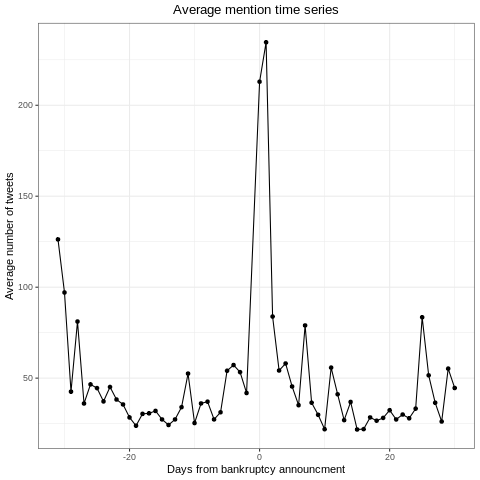

In [ ]:
%%R
p2<-ggplot(data=fig2, aes(x=number, y=n_d)) +
                      geom_line()+
                      #scale_y_continuous(trans='log10')+
                      theme_bw() +
                      labs(x="Days from bankruptcy announcment", y = "Average number of tweets")+
                      ggtitle("Average mention time series") +
                      theme(plot.title = element_text(hjust = 0.5)) +
                      #geom_hline(yintercept=mean(fig2[fig2$number!=0,]$n_d), linetype="dashed", color = "red") +
                      geom_point()

print(p2)

ggexport(p2, filename = "figures3.pdf", width = 6, height = 6) # write figure to pdf

## Four (4) measures

1. Pre-announcement mean: arithmetic mean of days -30 through 0 before bankruptcy announcement.
    
2. Short-term boost: maximum mentions during days 0 through 6 after bankruptcy announcement, minus the pre-announcement mean.

3. Long-term boost: arithmetic mean of days 7 through 30 after bankruptcy announcement, minus the pre-announcement mean.

4. Halving time: number of days required to accumulate half of the total area between the post-announcement curve (including the day of the announcement) and the minimum post-announcement value.


In [ ]:
%%R
tmp <- read_csv("/content/drive/MyDrive/Colab Notebooks/BIU_HEB/data/data_rebuttle.csv")

# remove TailorBrands
tmp <- tmp[!tmp$company %in% c('TailorBrands', 'DeanAndDeLuca'),]

tmp <- tmp[! tmp$company %in% c('KikoMilanoUSA','CharmingCharlie'),]

head(tmp)

In [ ]:
%%R
# 1) Pre-announcement mean
Pre_announcement_mean = sqldf("select avg(freq) as avgfreq, company from tmp where `when`='before' group by company")
Pre_announcement_mean

      avgfreq        company
1    7.633333 CharlotteRusse
2   23.888889         DIESEL
3  172.766667      Forever21
4   18.344828   MattressFirm
5    6.633333       NineWest
6   16.782609     Perfumania
7    4.913043       Rockport
8  130.689655          Sears
9    9.827586   TrueReligion
10   1.954545   beautybrands
11  71.740741        claires
12  19.857143     ftdflowers
13  46.666667        hhgregg
14  52.758621          rue21
15  17.482759      sugarfina


In [ ]:
%%R
# 2) Short-term boost
Short_term_boost = sqldf("select max(freq) as shrt_boost, company from tmp where `when`='after' and number between 0 and 6 group by company")
Short_term_boost$shrt_boost <- Short_term_boost$shrt_boost - Pre_announcement_mean$avgfreq
print(Short_term_boost)


print(paste0("median short-term boost ", median(Short_term_boost$shrt_boost)))



library(DescTools)
MedianCI(Short_term_boost$shrt_boost,
         conf.level = 0.95,
         na.rm = FALSE,
         method = "exact",
         R = 10000)

     shrt_boost        company
1    79.3666667 CharlotteRusse
2    15.1111111         DIESEL
3   847.2333333      Forever21
4   201.6551724   MattressFirm
5    57.3666667       NineWest
6    -0.7826087     Perfumania
7    12.0869565       Rockport
8  1632.3103448          Sears
9   384.1724138   TrueReligion
10   14.0454545   beautybrands
11  189.2592593        claires
12    3.1428571     ftdflowers
13   34.3333333        hhgregg
14   22.2413793          rue21
15   -4.4827586      sugarfina
[1] "median short-term boost 34.3333333333333"
   median    lwr.ci    upr.ci 
 34.33333  12.08696 201.65517 
attr(,"conf.level")
[1] 0.9648438


In [ ]:
%%R
# 3) Long-term boost
Long_term_boost = sqldf("select avg(freq) as lng_boost, company from tmp where `when`='after' and number between 7 and 40 group by company")
Long_term_boost$shrt_boost <- Long_term_boost$lng_boost - Pre_announcement_mean$avgfreq

print(Long_term_boost)

library(DescTools)
MedianCI(Long_term_boost$shrt_boost,
         conf.level = 0.95,
         na.rm = FALSE,
         method = "exact",
         R = 10000)

    lng_boost        company  shrt_boost
1    6.523810 CharlotteRusse  -1.1095238
2   22.458333         DIESEL  -1.4305556
3  106.739130      Forever21 -66.0275362
4   28.291667   MattressFirm   9.9468391
5    5.772727       NineWest  -0.8606061
6   19.833333     Perfumania   3.0507246
7    3.500000       Rockport  -1.4130435
8   95.625000          Sears -35.0646552
9   12.208333   TrueReligion   2.3807471
10   3.181818   beautybrands   1.2272727
11 151.333333        claires  79.5925926
12   2.789474     ftdflowers -17.0676692
13  11.375000        hhgregg -35.2916667
14  42.541667          rue21 -10.2169540
15   3.850000      sugarfina -13.6327586
    median     lwr.ci     upr.ci 
 -1.413043 -17.067669   2.380747 
attr(,"conf.level")
[1] 0.9648438


In [ ]:
%%R
# Halving time - manual run: play with `win` variable to detect when the area under the graph (`x`) is 0.5
# calculate AUC

comp = 'TrueReligion'
win = 3
x = AUC(x=tmp[tmp$when =='after'& tmp$company==comp,]$number[1:win], y=tmp[tmp$when =='after'& tmp$company==comp,]$freq[1:win]) / 
                                                                    AUC(x=tmp[tmp$when =='after'& tmp$company==comp,]$number, y=tmp[tmp$when =='after'& tmp$company==comp,]$freq)

print(x)

[1] 0.5923533


In [ ]:
%%R



halving = rbind(
    c('beautybrands',	7),
    c('CharlotteRusse',	5),
    #c('CharmingCharlie',	5),
    c('claires',	21),
    c('DIESEL',	17),
    c('Forever21',	7),
    c('ftdflowers',	14),
    c('hhgregg',	9),
    c('MattressFirm',	14),
    c('NineWest',	5),
    c('Perfumania',	12),
    c('Rockport',	11),
    c('rue21',	15),
    c('Sears',	4),
    c('sugarfina',	13),
    c('TrueReligion',	3)
)


halving = data.frame(halving)
names(halving) = c("company","halving")
halving

          company halving
1    beautybrands       7
2  CharlotteRusse       5
3         claires      21
4          DIESEL      17
5       Forever21       7
6      ftdflowers      14
7         hhgregg       9
8    MattressFirm      14
9        NineWest       5
10     Perfumania      12
11       Rockport      11
12          rue21      15
13          Sears       4
14      sugarfina      13
15   TrueReligion       3


## clustering

In [ ]:
%%R
df_four_measures = data.frame(
                              'Pre_announcement_mean' = Pre_announcement_mean$avgfreq, 
                              'Short_term_boost' = Short_term_boost$shrt_boost,
                              'Long_term_boost' = Long_term_boost$lng_boost,
                              'Halving' = as.numeric(halving$halving)
                              )

df_four_measures

   Pre_announcement_mean Short_term_boost Long_term_boost Halving
1               7.633333      79.36666667        6.523810       7
2               1.941176       0.05882353        1.375000       5
3              23.888889      15.11111111       22.458333       5
4             172.766667     847.23333333      106.739130      21
5              18.344828     201.65517241       28.291667      17
6               6.633333      57.36666667        5.772727       7
7              16.782609      -0.78260870       19.833333      14
8               4.913043      12.08695652        3.500000       9
9             130.689655    1632.31034483       95.625000      14
10              9.827586     384.17241379       12.208333       5
11              1.954545      14.04545455        3.181818      12
12             71.740741     189.25925926      151.333333      11
13             19.857143       3.14285714        2.789474      15
14             46.666667      34.33333333       11.375000       4
15        

In [ ]:
%%R
mat = as.matrix(df_four_measures)

In [ ]:
%%R

res<-NbClust(mat, distance = "euclidean", min.nc=2, max.nc=10, method = "kmeans", index = "all")

# plot
library("factoextra")
fviz_nbclust(res)

In [ ]:
%%R
# do k-means
kmeans_fancy <- kmeans(scale(mat), 2, nstart = 100)


df_four_measures$company <- halving$company
df_four_measures$kmeans <- kmeans_fancy$cluster
df_four_measures

   Pre_announcement_mean Short_term_boost Long_term_boost Halving
1               7.633333      79.36666667        6.523810       7
2               1.941176       0.05882353        1.375000       5
3              23.888889      15.11111111       22.458333       5
4             172.766667     847.23333333      106.739130      21
5              18.344828     201.65517241       28.291667      17
6               6.633333      57.36666667        5.772727       7
7              16.782609      -0.78260870       19.833333      14
8               4.913043      12.08695652        3.500000       9
9             130.689655    1632.31034483       95.625000      14
10              9.827586     384.17241379       12.208333       5
11              1.954545      14.04545455        3.181818      12
12             71.740741     189.25925926      151.333333      11
13             19.857143       3.14285714        2.789474      15
14             46.666667      34.33333333       11.375000       4
15        

R[write to console]: file saved to figures3c.pdf



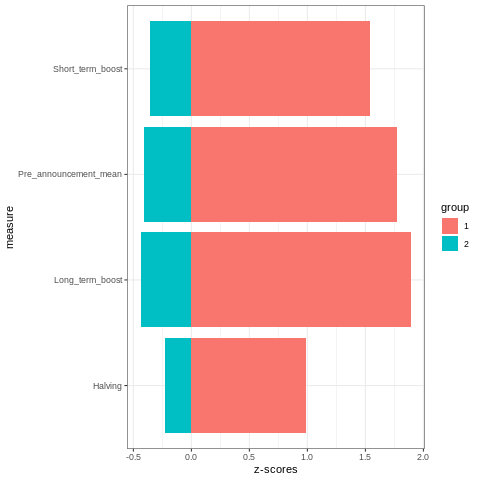

In [ ]:
%%R
df_centroids = data.frame(kmeans_fancy$centers)
df_centroids <- t(df_centroids)
df_centroids <- data.frame(df_centroids)
df_centroids$measure<-row.names(df_centroids)
row.names(df_centroids)<-NULL

one <- data.frame(df_centroids[,c(1,3)])
one$group<-"1"
names(one)[1]<-"z-scores"
two <- data.frame(df_centroids[,c(2,3)])
two$group<-'2'
names(two)[1]<-"z-scores"

df_centroids<-rbind(one, two)

# do k-means
g<- ggplot(df_centroids, aes(measure,`z-scores`,fill=group)) +
  geom_col()+
  theme_bw() +
  coord_flip()

print(g)
ggexport(g, filename = "figures3c.pdf", width = 4, height = 4) # write figure to pdf

In [ ]:
%%R
df_four_measures

   Pre_announcement_mean Short_term_boost Long_term_boost Halving
1               7.633333      79.36666667        6.523810       7
2               1.941176       0.05882353        1.375000       5
3              23.888889      15.11111111       22.458333       5
4             172.766667     847.23333333      106.739130      21
5              18.344828     201.65517241       28.291667      17
6               6.633333      57.36666667        5.772727       7
7              16.782609      -0.78260870       19.833333      14
8               4.913043      12.08695652        3.500000       9
9             130.689655    1632.31034483       95.625000      14
10              9.827586     384.17241379       12.208333       5
11              1.954545      14.04545455        3.181818      12
12             71.740741     189.25925926      151.333333      11
13             19.857143       3.14285714        2.789474      15
14             46.666667      34.33333333       11.375000       4
15        

## figure 3. average mention time series by group

In [ ]:
%%R
tmp <- read_csv("/content/drive/MyDrive/Colab Notebooks/BIU_HEB/data/data_rebuttle.csv", show_col_types = FALSE)

# remove TailorBrands
tmp <- tmp[!tmp$company %in% c('KikoMilanoUSA', ''),]

head(tmp[tmp$when == 'after',])

New names:
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
# A tibble: 6 × 9
  company      date        freq when  number ...6  ...7  ...8  ...9 
  <chr>        <chr>      <dbl> <chr>  <dbl> <lgl> <lgl> <lgl> <lgl>
1 beautybrands 07/01/2019    16 after      1 NA    NA    NA    NA   
2 beautybrands 08/01/2019     3 after      2 NA    NA    NA    NA   
3 beautybrands 09/01/2019     7 after      3 NA    NA    NA    NA   
4 beautybrands 12/01/2019     5 after      6 NA    NA    NA    NA   
5 beautybrands 13/01/2019     6 after      7 NA    NA    NA    NA   
6 beautybrands 16/01/2019     3 after     10 NA    NA    NA    NA   


In [ ]:
%%R
group1<-tmp[tmp$company %in% df_four_measures[df_four_measures$kmeans==1,]$company,]
group1$group<-'C1'
group2<-tmp[tmp$company %in% df_four_measures[df_four_measures$kmeans==2,]$company,]
group2$group<-'C2'
group_data <- rbind(group1,group2)
fig3b <- sqldf("select number, `group`, avg(freq) as n_d from group_data group by number, `group`")
fig3b$group <- as.factor(fig3b$group)
head(fig3b)

  number group       n_d
1    -31    C2 126.28571
2    -30    C1  14.50000
3    -30    C2 103.36364
4    -29    C1  10.00000
5    -29    C2  44.72727
6    -28    C1  17.66667


R[write to console]: file saved to figures3b.pdf



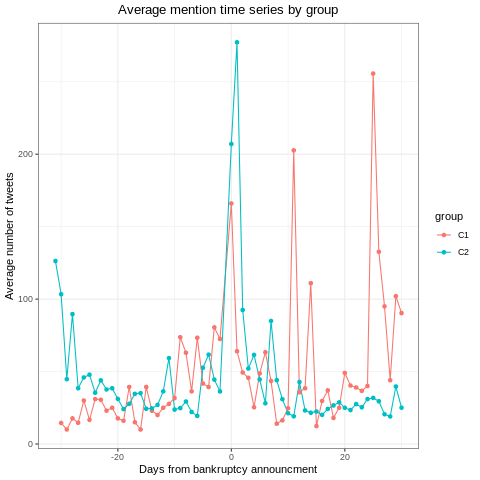

In [ ]:
%%R
p2<-ggplot(data=fig3b, aes(x=number, y=n_d, group=group, colour=group)) +
                      geom_line()+
                      theme_bw() +
                      labs(x="Days from bankruptcy announcment", y = "Average number of tweets")+
                      ggtitle("Average mention time series by group") +
                      theme(plot.title = element_text(hjust = 0.5)) +
                      geom_point()

print(p2)

ggexport(p2, filename = "figures3b.pdf", width = 6, height = 6) # write figure to pdf

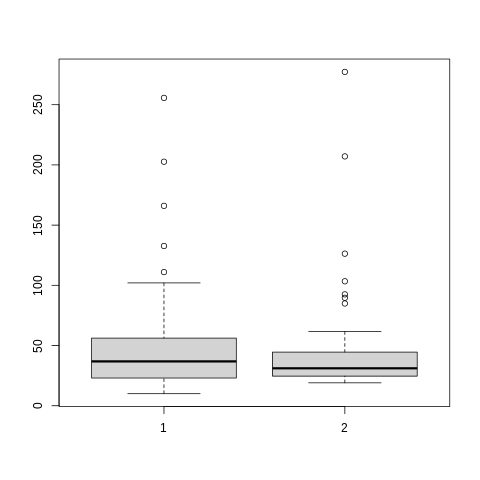

In [ ]:
%%R
boxplot(fig3b[fig3b$group=='C1',]$n_d, fig3b[fig3b$group=='C2',]$n_d)

In [ ]:
%%R
# mean of 3 out of the 4 parameters in each cluster
# mean(df_four_measures$Short_term_boost

#mean(df_four_measures[df_four_measures$kmeans=='1',]$Short_term_boost)
mean(df_four_measures[df_four_measures$kmeans=='2',]$Short_term_boost)

# Short_term_boost      C1: 617.7155           C2: 107.0955            ALL  298.578
# Long_term_boost       C1: 70.03487           C2 15.3411              ALL  35.85126
# Pre_announcement_mean C1: 51.11              C2 16.80455             ALL  29.67202

[1] 62.94734


## regression

1. Pre-announcement mean mention frequency.
2. Company age (year) at the day of bankruptcy announcement.
3. Bankruptcy strategy (factor with 5 levels: restructuring, reorganization, purchased, sold, closed all stores).
4. Market cup category (factor with 6 levels: specifying the main business of the company: sports, clothes, etc.
5. Market capitalization.
6. Gender of owners (factor with 3 levels: female, male, mixed).




In [ ]:
%%R
Pre_announcement_mean$avgfreq<-scale(Pre_announcement_mean$avgfreq)
Pre_announcement_mean

      avgfreq         company
1  -0.6115239  CharlotteRusse
2  -0.7271324 CharmingCharlie
3  -0.2813710          DIESEL
4   2.7423597       Forever21
5  -0.3939717    MattressFirm
6  -0.6318340        NineWest
7  -0.4257007      Perfumania
8  -0.6667734        Rockport
9   1.8877691           Sears
10 -0.5669582    TrueReligion
11 -0.7268609    beautybrands
12  0.6905075         claires
13 -0.3632564      ftdflowers
14  0.1812492         hhgregg
15  0.3049777           rue21
16 -0.4114805       sugarfina


In [ ]:
# average sentiment analysis of each company
# load before and after datasets
%%R

before <- read_csv(paste0(PTH1,"/before.csv"),col_types = cols(...1 = col_skip(), id = col_character(),
                                                                       in_reply_to_user_id = col_character(),
                                                                       author_id = col_character(), 
                                                                       conversation_id = col_character()))


before<-before[!before$company %in% c('DeanAndDeLuca', 'TailorBrands'),]

New names:
• `` -> `...1`


In [ ]:
%%R
tweets_R = before$text

In [ ]:
%R -o tweets_R tweets_R

"""There we...",'RT @Nint...,'RT @Nint...,...,'RT @hhgr...,'RT @hhgr...,"""@hhgregg..."


In [ ]:
import re
result = [re.sub(r'http\S+', '', x) for x in tweets_R]

In [ ]:
# https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
from textblob import TextBlob

sentiment = []
subjectivity = []

for text in result:
  x = TextBlob(text)
  sentiment.append( x.sentiment[0] )
  subjectivity.append( x.sentiment[1] ) # The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [ ]:
# send back sentiment to R
%R -i sentiment sentiment
%R -i subjectivity subjectivity

## T-tests

In [ ]:
%%R
# reputation ratio
cl1=c(36.01754386,
56.8627451,
132.7731092,
146.4516129,
162.406015,
67700)


cl2=c(49.26624738,
85.17520216,
111.9669421,
113.8297872,
117.0572207,
144.9460647,
169.4719472,
203.6018957,
311.2852665,
74100)


wilcox.test(cl1,cl2)


	Wilcoxon rank sum exact test

data:  cl1 and cl2
W = 27, p-value = 0.7925
alternative hypothesis: true location shift is not equal to 0



In [ ]:
%%R
# difference in the number of Followers

cluster1=c(67700,
43200,
22700,
14500,
110600,
6159)


cluster2=c(192600,
102700,
74100,
23500,
99300,
214800,
429600,
338700,
63200,
362800)


t.test(cluster1,cluster2)


	Welch Two Sample t-test

data:  cluster1 and cluster2
t = -3.0489, df = 11.109, p-value = 0.01095
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -251248.32  -40725.35
sample estimates:
mean of x mean of y 
 44143.17 190130.00 



In [ ]:
%%R
# difference in the number of lists

clst1=c(171,
255,
833,
155,
266,
1)


clst2=c(477,
742,
3025,
1692,
1835,
2503,
606,
2110,
319,
1)


t.test(clst1,clst2)


	Welch Two Sample t-test

data:  clst1 and clst2
t = -3.0244, df = 11.129, p-value = 0.01143
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1814.4995  -287.1672
sample estimates:
mean of x mean of y 
 280.1667 1331.0000 



In [ ]:
%%R
# list into vector
sentiment = unlist(sentiment)
subjectivity = unlist(subjectivity)

In [ ]:
%%R
before$sentiment <- sentiment
before$subjectivity <- subjectivity

mean_sent_by_comp = sqldf("select avg(sentiment), company from before group by company")

mean_subj_by_comp = sqldf("select avg(subjectivity), company from before group by company")


mean_sent_by_comp<-mean_sent_by_comp[!mean_sent_by_comp$company %in% c('KikoMilanoUSA', ''),]
mean_subj_by_comp<-mean_subj_by_comp[!mean_subj_by_comp$company %in% c('KikoMilanoUSA', ''),]

In [ ]:
%%R
# number of tweets before
num_of_tweets_before = sqldf("select company, count(1) as n_tweets from before group by company")
num_of_tweets_before = num_of_tweets_before[num_of_tweets_before$company != "KikoMilanoUSA",]
num_of_tweets_before

           company n_tweets
1   CharlotteRusse      229
2  CharmingCharlie       33
3           DIESEL      645
4        Forever21     5183
6     MattressFirm      537
7         NineWest      199
8       Perfumania      386
9         Rockport      120
10           Sears     3797
11    TrueReligion      286
12    beautybrands       43
13         claires     1938
14      ftdflowers      557
15         hhgregg     1260
16           rue21     1531
17       sugarfina      507


In [ ]:
%%R
unique(before$company)

 [1] "sugarfina"       "Forever21"       "CharmingCharlie" "ftdflowers"     
 [5] "DIESEL"          "CharlotteRusse"  "beautybrands"    "Sears"          
 [9] "MattressFirm"    "Rockport"        "NineWest"        "claires"        
[13] "KikoMilanoUSA"   "Perfumania"      "TrueReligion"    "rue21"          
[17] "hhgregg"        


In [ ]:
%%R
# calculate mean inter-tweet time
inter_tweet_time = data.frame()
for(company in unique(before$company)){
    v = as.POSIXct( before[before$company==company,]$created_at , format = "%a %b %d %H:%M:%S %z %Y", tz="GMT")
    v = v[order(v , decreasing = TRUE )]
    d = diff(v)
    inter_tweet_time = rbind(inter_tweet_time, c(company, mean(d)))
}

names(inter_tweet_time) = c('company','avg_inter_time')
#inter_tweet_time = inter_tweet_time[order(num_of_tweets_before$company),]
inter_tweet_time = sqldf("select company, avg_inter_time/60 as avg_inter_time from inter_tweet_time group by company") # we do this to keep the order of companies
inter_tweet_time <- inter_tweet_time[inter_tweet_time$company != 'KikoMilanoUSA',]
inter_tweet_time

           company    avg_inter_time
1   CharlotteRusse -183.459210526315
2  CharmingCharlie -20.2715711805555
3           DIESEL -60.2850672877847
4        Forever21 -8.32957673999743
6     MattressFirm -77.8626865671642
7         NineWest -214.747643097643
8       Perfumania -106.192337662338
9         Rockport -317.968207282913
10           Sears -10.9990735862311
11    TrueReligion -142.552631578947
12    beautybrands -16.5759457671958
13         claires  -20.065969712614
14      ftdflowers -74.8082434052758
15         hhgregg -30.8718030182685
16           rue21 -27.2831045751633
17       sugarfina -84.9220355731225


In [ ]:
%%R

Company_type = c( 'Beauty',
                  'Clothing',
                  'Clothing',
                  'Department Store',
                  'Clothing',
                  'Clothing',
                  'Other',
                  'Department Store',
                  #'Beauty',
                  'Mattresses',
                  'Clothing',
                  'Beauty',
                  'Clothing',
                  'Other',
                  'Department Store',
                  'Other',
                  'Clothing'
                  )
                  
Followers = c(8403,
              72100,
              28500,
              65400,
              179000,
              1900000,
              12800,
              31800,
              #4367,
              47200,
              45400,
              19000,
              6294,
              32400,
              198100,
              22300,
              44600)


Following = c(
                707,
                9438,
                148,
                225,
                737,
                351,
                21,
                900,
                #47,
                554,
                387,
                159,
                940,
                1091,
                9293,
                172,
                193
                )

# mean web searched worldwide 1 month before the announcedment on Google Trends
Google_trends = c(
                  69.84,
                  74.9,
                  59.45,
                  35.86,
                  84.86,
                  54.93,
                  25.31,
                  50.06,
                  #
                  30.77,
                  64.93,
                  62.46,
                  87.38,
                  65.19,
                  28,
                  32.75,
                  11.51
                  )

public = c( 'Private',
            'Private',
            'Private',
            'Private',
            'Private',
            'Private',
            'Public',
            'Public',
            #'Private',
            'Private',
            'Private',
            'Public',
            'Private', 
            'Private',
            'Public',
            'Private', 
            'Private')

In [ ]:
%%R

df = data.frame(
                  'company' = Pre_announcement_mean$company,
                  'Pre_announcement_mean' = Pre_announcement_mean$avgfreq, 
                  'Company_type' = as.factor(Company_type), 
                  'Short_term_boost' = Short_term_boost$shrt_boost,
                  'Long_term_boost' = Long_term_boost$shrt_boost,
                  'avg_inter_time' = inter_tweet_time$avg_inter_time,
                  'num_of_tweets_before' = num_of_tweets_before$n_tweets,
                  'Followers' = Followers,
                  'Following' = Following,
                  'Google_trends' = Google_trends,
                  'public' = as.factor(public)
                )

In [ ]:
%%R
length(num_of_tweets_before$n_tweets)

[1] 16


In [ ]:
# *** predicct short-term boost ***
%%R

df$Company_type <- relevel(df$Company_type, ref = 'Clothing') # Clothing
df$public <- relevel(df$public, ref = 'Private')


library(MASS)
# Fit the full model 
full.model <-lm(df$Short_term_boost ~ 
                                df$Pre_announcement_mean +
                                #df$mean_sent_by_comp +
                                #df$avg_inter_time +
                                df$Company_type +
                                df$Google_trends +
                                df$num_of_tweets_before +
                                df$public
                                #+df$Followers+
                                #df$Following +
                                #df$mean_subj_by_comp
                )

# Stepwise regression model
step.model <- stepAIC(full.model, direction = "both", 
                      trace = FALSE)
summary(step.model)


Call:
lm(formula = df$Short_term_boost ~ df$Pre_announcement_mean + 
    df$Company_type + df$Google_trends + df$num_of_tweets_before + 
    df$public)

Residuals:
   Min     1Q Median     3Q    Max 
-85.76 -52.15 -17.59  12.49 252.08 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -1797.9842   794.0483  -2.264  0.05796 .  
df$Pre_announcement_mean        -2244.8735  1005.6039  -2.232  0.06076 .  
df$Company_typeBeauty            -139.4301   127.4465  -1.094  0.31015    
df$Company_typeDepartment Store  -151.4306   165.2964  -0.916  0.39008    
df$Company_typeMattresses        1107.1338   181.4265   6.102  0.00049 ***
df$Company_typeOther             -122.1629    98.9935  -1.234  0.25700    
df$Google_trends                    2.6056     1.8317   1.422  0.19789    
df$num_of_tweets_before             1.7068     0.7012   2.434  0.04515 *  
df$publicPublic                   154.7660   144.9097   1.068  0.32095   

In [ ]:
%%R
df

           company Pre_announcement_mean     Company_type Short_term_boost
1   CharlotteRusse            -0.6115239           Beauty      79.36666667
2  CharmingCharlie            -0.7271324         Clothing       0.05882353
3           DIESEL            -0.2813710         Clothing      15.11111111
4        Forever21             2.7423597 Department Store     847.23333333
5     MattressFirm            -0.3939717         Clothing     201.65517241
6         NineWest            -0.6318340         Clothing      57.36666667
7       Perfumania            -0.4257007            Other      -0.78260870
8         Rockport            -0.6667734 Department Store      12.08695652
9            Sears             1.8877691       Mattresses    1632.31034483
10    TrueReligion            -0.5669582         Clothing     384.17241379
11    beautybrands            -0.7268609           Beauty      14.04545455
12         claires             0.6905075         Clothing     189.25925926
13      ftdflowers       

In [ ]:
# *** predict long-term boost ***
%%R
model2<-lm(log(Long_term_boost) ~     Pre_announcement_mean +
                                      #as.numeric(avg_inter_time) +
                                      Followers + 
                                      Short_term_boost,
                                    data = df
                                      )
                                      

summary(model2)


Call:
lm(formula = log(Long_term_boost) ~ Pre_announcement_mean + Followers + 
    Short_term_boost, data = df)

Residuals:
         5          7         10         11         12 
-0.0001057  0.0251870  0.0037865 -0.0231138 -0.0057540 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)   
(Intercept)            2.280e+00  2.640e-02  86.370  0.00737 **
Pre_announcement_mean  2.999e+00  3.269e-02  91.756  0.00694 **
Followers              6.765e-06  2.633e-07  25.691  0.02477 * 
Short_term_boost      -6.078e-05  1.184e-04  -0.514  0.69799   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03487 on 1 degrees of freedom
  (11 observations deleted due to missingness)
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9995 
F-statistic:  2951 on 3 and 1 DF,  p-value: 0.01353



In [ ]:
%%R
(df$Long_term_boost)

 [1]  -1.1095238  -0.5661765  -1.4305556 -66.0275362   9.9468391  -0.8606061
 [7]   3.0507246  -1.4130435 -35.0646552   2.3807471   1.2272727  79.5925926
[13] -17.0676692 -35.2916667 -10.2169540 -13.6327586


In [ ]:
%%R
names(df)

 [1] "company"               "Pre_announcement_mean" "Company_type"         
 [4] "Short_term_boost"      "Long_term_boost"       "avg_inter_time"       
 [7] "num_of_tweets_before"  "Followers"             "Following"            
[10] "Google_trends"         "public"               
